In [42]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import random
import numpy as np
from qiskit.result import marginal_counts
from qiskit_aer import Aer

In [43]:
def create_registers():
    alice_q = QuantumRegister(1, name='alice (q)')
    peter_alice_q = QuantumRegister(1, name='peter/alice (q)')
    peter_bob_q = QuantumRegister(1, name='peter/bob (q)')
    bob_c = ClassicalRegister(3, name='bob (c)')
    circ = QuantumCircuit(alice_q, peter_alice_q, peter_bob_q, bob_c)
    return circ

In [ ]:
create_registers().draw(output='mpl')


In [44]:
def generate_amplitudes():
    alpha = np.sqrt(random.uniform(0, 1))
    beta = np.sqrt(1 - alpha**2)
    return alpha, beta

In [45]:
def add_gates(circ, alpha, beta):
    circ.initialize([alpha, beta], 0)
    circ.barrier()
    circ.h(1)
    circ.cx(1, 2)
    circ.barrier()
    circ.cx(0, 1)
    circ.h(0)
    circ.barrier()
    circ.measure(0,0)
    circ.measure(1,1)
    with circ.if_test((1,1)): # normal 'if' statement does not work here. The gate would be created at the creation
                              # of the circuit and not at the moment when the circuit is working
        circ.x(2)
    with circ.if_test((0,1)):
        circ.z(2)
    circ.measure(2,2)
    return circ

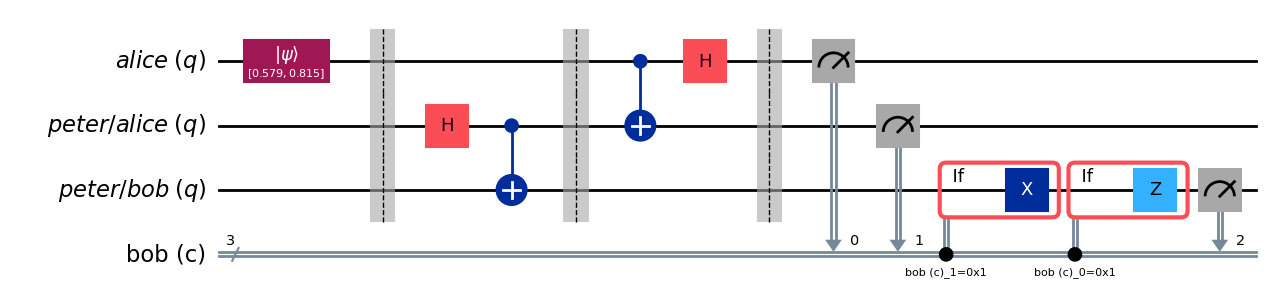

In [62]:
circuit = create_registers()
alpha, beta = generate_amplitudes()
circuit = add_gates(circuit, alpha, beta)
circuit.draw(output='mpl')

Workaround from: 
https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/transpiler-passes-scheduling#scheduling-old-format-c_if-conditioned-gates

In [ ]:
qc_c_if = QuantumCircuit(1,1)
qc_c_if.x(0).c_if(0, 1)
qc_c_if.draw(output='mpl', style='iqp')

In [ ]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passmanager import PassManager

from qiskit.circuit.library import XGate, ZGate

from qiskit_ibm_runtime.transpiler.passes.scheduling import DynamicCircuitInstructionDurations
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis
from qiskit_ibm_runtime.transpiler.passes.scheduling import PadDynamicalDecoupling

from qiskit_ibm_runtime.fake_provider import FakeJakartaV2

backend = FakeJakartaV2()

#backend = Aer.get_backend("qasm_simulator")

durations = DynamicCircuitInstructionDurations.from_backend(backend)

dd_sequence = [XGate(), XGate()]

# Temporary workaround for mock backends. For real backends this is not required.
backend.get_translation_stage_plugin = lambda: "ibm_dynamic_circuits"
 
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(durations),
        PadDynamicalDecoupling(durations, dd_sequence),
    ]
)
 
qc_if_dd = pm.run(qc_c_if, backend)
qc_if_dd.draw(output="mpl", style="iqp")

Back to original code

In [64]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passmanager import PassManager

from qiskit.circuit.library import XGate, ZGate

from qiskit_ibm_runtime.transpiler.passes.scheduling import DynamicCircuitInstructionDurations
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis
from qiskit_ibm_runtime.transpiler.passes.scheduling import PadDynamicalDecoupling

from qiskit_ibm_runtime.fake_provider import FakeJakartaV2

backend = FakeJakartaV2()
durations = DynamicCircuitInstructionDurations.from_backend(backend)

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(durations),
        PadDynamicalDecoupling(durations, dd_sequence),
    ]
)

scheduled_teleport = pm.run(circuit)
scheduled_teleport.draw(output="mpl", style="iqp")
#device = Aer.get_backend('qasm_simulator')
#new_circuit = transpile(circuit, device,optimization_level=2)
#new_circuit = qiskit.compiler.transpile(circuit, device,optimization_level=2)

nshots = 10000
job = backend.run(scheduled_teleport, shots=nshots)
# #job = device.run(circuit, nshots)
print(job.job_id())

result = job.result()
counts = result.get_counts(scheduled_teleport)
print(counts)
counts_m = marginal_counts(counts, [2])
number_of_0s = counts_m.get('0')
number_of_1s = counts_m.get('1')
alpha = np.sqrt(number_of_0s/nshots)
beta = np.sqrt(number_of_1s/nshots)
print("|\u03C8\u27E9 ({:.4f}, {:.4f})".format(alpha, beta))

6a2dc149-715d-4d66-aad8-dbcecd024687
{'001': 906, '111': 1539, '011': 851, '110': 1621, '010': 921, '000': 944, '101': 1591, '100': 1627}
|ψ⟩ (0.6018, 0.7986)
